In [1]:
import pandas as pd
import numpy as np
import rioxarray
import json, os

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
seed = 42
verbose = False
details = True

In [3]:
INVASIVE_BIRDS_PATH = 'Datasets/Machine Learning/1km Rasters/Birds'
# Use this if using coordinates as separate columns
# df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv')

# Use this if using coordinates as indices
df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv', index_col=[0,1])

total_birds = (df_1km['Occurrence']==1).sum()
df_dicts = []

for file in os.listdir(INVASIVE_BIRDS_PATH):
    filename = os.fsdecode(file)
    if not filename.endswith('.tif') or filename.endswith('All_Invasive_Birds_1km.tif') :
         continue



    bird_name = filename[:-4].replace('_', ' ')

    bird_dataset = rioxarray.open_rasterio(f'{INVASIVE_BIRDS_PATH}/{file}')
    bird_dataset.name = 'data'
    bird_df = bird_dataset.squeeze().drop("spatial_ref").drop("band").to_dataframe()

    # Check if index matches
    if not df_1km.index.equals(bird_df.index):
        print('Warning: Index does not match')
        continue

    bird_df['Occurrence'] = [0 if x == -1 else 1 for x in bird_df['data']]
    bird_df = df_1km.drop(columns='Occurrence').join(bird_df.drop(columns='data'))
    
    bird_dict = {'name' : bird_name, 'dataframe' : bird_df }
    df_dicts.append(bird_dict)
    display(bird_df.sample(5))


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
210500.0,458500.0,17,0,52,30,0,0,0,0,0,0,...,1.708913e+01,7.608381e+00,2.782641e+00,8.605974e+00,8.541364e+00,4.872463e+00,1.886089e+01,1.385952e+01,1.371158e+01,0
995500.0,601500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
300500.0,618500.0,17,0,46,18,0,0,0,0,0,0,...,1.386673e+01,1.642136e+00,1.971480e+00,7.683126e+00,8.405563e+00,7.249522e-01,3.250140e+00,3.704372e+00,3.392229e+00,0
12500.0,338500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
597500.0,399500.0,0,4,0,0,0,0,0,0,96,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
221500.0,502500.0,0,0,2,3,0,0,0,0,0,0,...,1.756213e-02,1.720418e-03,4.031708e-03,-3.400000e+38,5.754761e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
794500.0,60500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
547500.0,674500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
228500.0,256500.0,10,1,0,80,0,0,8,0,0,0,...,4.691394e-01,7.202167e-01,5.701302e-01,1.139177e+00,4.138628e-01,4.975241e-01,3.603367e-01,8.818065e-02,6.709322e-01,0
904500.0,96500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
491500.0,463500.0,8,4,1,47,0,11,0,0,7,23,...,2.552632e-01,4.633016e-02,1.943011e-01,-3.400000e+38,1.751061e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
415500.0,12500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
617500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
832500.0,300500.0,0,0,0,0,0,0,0,0,100,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
929500.0,459500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1100500.0,388500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
641500.0,640500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
421500.0,238500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
688500.0,183500.0,0,98,0,0,0,0,0,0,2,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
993500.0,590500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
75500.0,319500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
86500.0,311500.0,6,0,0,1,0,1,0,0,0,0,...,2.716818e-03,3.315273e-04,1.605283e-03,-3.400000e+38,1.047427e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1254500.0,606500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
274500.0,631500.0,0,0,65,30,0,0,0,0,0,0,...,2.496213e+01,3.442879e+00,3.434172e+00,2.874435e+00,1.414938e+01,1.705149e+00,6.048480e+00,3.643768e+00,7.355608e+00,0
471500.0,519500.0,0,0,90,6,0,0,0,0,0,0,...,1.506880e+01,1.530977e+01,5.076050e+00,9.553390e+00,1.567872e+01,1.130232e+01,1.062081e+01,7.042382e+00,1.348234e+01,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1289500.0,146500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1037500.0,237500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
327500.0,104500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
155500.0,486500.0,0,0,0,0,0,0,0,0,0,0,...,1.335905e-02,1.131381e-03,3.626722e-03,-3.400000e+38,3.725381e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
899500.0,209500.0,6,0,0,1,0,0,0,0,0,83,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
922500.0,509500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
120500.0,410500.0,2,0,92,4,0,0,0,0,0,0,...,5.567024e+01,1.320240e+00,7.980333e+00,2.178659e-02,1.725411e+01,1.156848e-02,1.226339e+01,5.671224e+00,8.835752e+00,0
556500.0,604500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
788500.0,673500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
546500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
840500.0,675500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
751500.0,399500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
641500.0,605500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
707500.0,578500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
84500.0,344500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1190500.0,180500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1062500.0,325500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
665500.0,648500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
655500.0,20500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1111500.0,482500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1050500.0,258500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1104500.0,335500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
217500.0,274500.0,0,0,0,0,0,0,100,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1020500.0,246500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
732500.0,439500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
974500.0,405500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
71500.0,445500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1222500.0,274500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
375500.0,469500.0,12,0,51,16,0,0,0,0,0,0,...,1.102861e+01,1.076760e+00,1.887839e+00,7.217796e+00,7.214385e+00,6.286643e-01,6.793458e+00,5.953130e+00,4.101244e+00,0
538500.0,354500.0,1,0,11,87,0,0,0,0,0,0,...,4.199960e-01,7.959555e-02,5.110549e-01,-3.400000e+38,2.692819e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
637500.0,286500.0,0,0,0,61,0,0,6,0,0,0,...,5.183865e-01,7.056607e-02,2.228176e-01,-3.400000e+38,1.624027e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
784500.0,646500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
103500.0,384500.0,0,0,96,3,0,0,0,0,0,0,...,5.581972e+01,1.260713e+00,6.174690e+00,-3.400000e+38,1.836491e+01,-3.400000e+38,1.129929e+01,4.079481e+00,8.705502e+00,0
207500.0,217500.0,27,0,16,21,0,0,0,0,0,0,...,1.724084e-01,3.704135e-02,2.476914e-01,-3.400000e+38,1.167010e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1129500.0,318500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
281500.0,383500.0,5,6,58,19,0,0,0,0,0,0,...,1.063023e+01,4.160291e+00,5.357363e+00,2.858755e+00,8.222045e+00,1.255364e+00,4.379103e+00,4.502326e+00,6.157461e+00,0
757500.0,517500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1030500.0,136500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1108500.0,69500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
175500.0,410500.0,0,0,94,3,0,0,0,0,0,0,...,4.713646e+01,1.032259e+00,6.678602e+00,-3.400000e+38,2.027867e+01,-3.400000e+38,2.101815e+01,7.201351e+00,1.526736e+01,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
284500.0,445500.0,3,0,93,3,0,0,0,0,0,0,...,2.458500e+01,1.001419e+00,4.695138e+00,-3.400000e+38,2.278710e+01,-3.400000e+38,1.749321e+01,2.188244e+01,1.407471e+01,0
779500.0,513500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
585500.0,307500.0,0,0,14,84,0,0,0,0,0,0,...,4.916749e+00,2.231230e-01,3.304013e+00,-3.400000e+38,1.349496e+00,-3.400000e+38,8.603682e-01,4.481045e-01,8.959922e-01,0
817500.0,521500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
390500.0,97500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1053500.0,538500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
261500.0,547500.0,11,0,1,31,0,0,0,0,0,0,...,1.289639e-01,2.276678e-02,4.382756e-02,-3.400000e+38,4.783259e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
682500.0,217500.0,8,76,0,0,0,0,14,0,1,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1000500.0,232500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1159500.0,168500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
977500.0,416500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
19500.0,457500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1069500.0,90500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
295500.0,439500.0,3,0,41,52,0,0,0,0,0,0,...,8.091403e+00,6.810439e+00,2.065955e+00,7.075270e+00,8.444314e+00,3.296879e+00,9.757885e+00,5.554022e+00,1.064113e+01,0
1053500.0,480500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
150500.0,48500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
700500.0,340500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
142500.0,605500.0,19,0,65,14,0,0,0,0,0,0,...,3.535822e+01,3.623691e+00,5.856493e+00,3.066536e+00,1.098517e+01,2.224410e+00,7.717764e+00,3.820922e+00,1.059968e+01,0
230500.0,262500.0,25,0,0,69,0,0,4,0,0,0,...,1.922603e-01,4.330866e-02,2.704217e-01,-3.400000e+38,1.295823e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
372500.0,201500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1263500.0,503500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1226500.0,653500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
217500.0,587500.0,7,0,86,3,0,0,0,0,0,0,...,3.026467e+01,1.387858e+01,7.357382e+00,1.434486e+01,1.611069e+01,1.062018e+01,1.557524e+01,3.998450e+00,1.456761e+01,0
176500.0,502500.0,2,0,45,27,0,0,0,0,0,0,...,1.921509e+01,6.230546e+00,2.146786e+00,6.279777e+00,1.331602e+01,4.220648e+00,1.814787e+01,4.173172e+00,1.486834e+01,0
177500.0,116500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
659500.0,356500.0,0,0,0,0,0,0,0,0,100,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
682500.0,186500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
840500.0,247500.0,61,0,0,39,0,0,0,0,0,0,...,7.728302e-02,1.611009e-02,6.161585e-02,-3.400000e+38,3.239392e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1055500.0,69500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
88500.0,439500.0,2,0,54,41,0,0,0,0,0,0,...,2.206366e+01,7.950239e+00,2.559340e+00,3.304436e+00,1.104135e+01,3.432077e+00,6.372918e+00,1.880297e+00,4.242424e+00,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
202500.0,235500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
857500.0,471500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
963500.0,192500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
49500.0,143500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
884500.0,21500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


In [4]:
# Data Cleaning
np.random.seed(seed=seed)

for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index 
    sample_size = sum(cur_df['Occurrence']==0) - total_birds + sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


# for dict in df_dicts:
#     cur_df = dict["dataframe"]
#     cur_df_name = dict["name"]

#     print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
#     no_occurences = cur_df[cur_df['Occurrence']==0].index
#     sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
#     random_indices = np.random.choice(no_occurences, sample_size, replace=False)
#     dict["dataframe"] =  cur_df.drop(random_indices)
    
#     print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')

Barnacle Goose 1km data before drop: 
 Occurrence
0    909231
1       769
dtype: int64 

Barnacle Goose 1km data after drop: 
 Occurrence
0    32315
1      769
dtype: int64 

Canada Goose 1km data before drop: 
 Occurrence
0    899853
1     10147
dtype: int64 

Canada Goose 1km data after drop: 
 Occurrence
0    22937
1    10147
dtype: int64 

Egyptian Goose 1km data before drop: 
 Occurrence
0    909137
1       863
dtype: int64 

Egyptian Goose 1km data after drop: 
 Occurrence
0    32221
1      863
dtype: int64 

Gadwall 1km data before drop: 
 Occurrence
0    907795
1      2205
dtype: int64 

Gadwall 1km data after drop: 
 Occurrence
0    30879
1     2205
dtype: int64 

Goshawk 1km data before drop: 
 Occurrence
0    909554
1       446
dtype: int64 

Goshawk 1km data after drop: 
 Occurrence
0    32638
1      446
dtype: int64 

Grey Partridge 1km data before drop: 
 Occurrence
0    907877
1      2123
dtype: int64 

Grey Partridge 1km data after drop: 
 Occurrence
0    30961
1     21

In [5]:
# Standardisation
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

In [6]:
# Feature Selection

# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [10, 15, 20, 25, 30, 35]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        # kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
        kbest_dict[str(num)] = best_X
    # kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])


    if details:
        print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

In [7]:
# Resample (upsample) minority data
# for dict in df_dicts:
#     if sum(dict['dataframe']['Occurence']==1) > sum(dict['dataframe']['Occurence']==0):
#         continue

# from sklearn.utils import resample

# def upsample(X, y):
#     X_1 = X[y['Occurrence'] == 1] # Getting positive occurrences (minority)
#     X_0 = X[y['Occurrence'] == 0] # Getting negative occurrences (majority)
    
#     X_1_upsampled = resample(X_1 ,random_state=seed,n_samples=total_birds/2,replace=True)


#     print(f'Resampling: \n {y.value_counts()} \n')


In [8]:
def oversample(X_train, y_train):
    over = RandomOverSampler(sampling_strategy='minority', random_state=seed)
    smote = SMOTE(random_state=seed, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    if details:
        print(f'Resampled Value Counts: \n {y_smote.value_counts()} \n')

    return X_smote, y_smote

In [9]:
All_bird_occurrences = pd.DataFrame([(dict['name'],sum(dict['dataframe']['Occurrence'] == 1)) for dict in df_dicts], columns=['Name', 'Occurrence Count'])
All_bird_occurrences['Percentage'] = All_bird_occurrences['Occurrence Count']/total_birds

All_bird_occurrences.sort_values('Occurrence Count', ascending=False)

,Name,Occurrence Count,Percentage
9,Mute Swan 1km,19124,0.578044
1,Canada Goose 1km,10147,0.306704
10,Pheasant 1km,5855,0.176974
16,Rock Dove 1km,3919,0.118456
7,Little Owl 1km,3548,0.107242
14,Red-legged Partridge 1km,2953,0.089258
11,Pink-footed Goose 1km,2646,0.079978
19,Wigeon 1km,2317,0.070034
3,Gadwall 1km,2205,0.066649
5,Grey Partridge 1km,2123,0.064170


In [10]:
# Add model pipeline
estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # Use this if using coordinates as separate columns
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    # Use this if using coordinates as indices
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(dict['X'], dict['y'])

    # dict['X'] = dict['kbest']['10'].transform(dict['X'])

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test # for debugging purposes

    dict['X_smote'], dict['y_smote'] = oversample(X_train, y_train)

    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    # Classifier without SMOTE
    stack_clf.fit(dict['X_train'], dict['y_train'])
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred, output_dict=True)
    

    # Classifier with SMOTE
    stack_clf.fit(dict['X_smote'], dict['y_smote'])
    y_pred_smote = stack_clf.predict(X_test)
    
    dict['predictions_smote'] = y_pred_smote
    dict['report_smote'] = classification_report(y_test, y_pred_smote, output_dict=True)
    
    print(f'{dict["name"]} Classification Report: \n {json.dumps(dict["report"], indent=4)} \n')
    print(f'{dict["name"]} SMOTE Classification Report: \n {json.dumps(dict["report_smote"], indent=4)} \n')



Training with Barnacle Goose 1km cells... 

K-Best Features Dataframe: 
        F Score        P Value                      Attribute
25  1586.660696   0.000000e+00   Inflowing drainage direction
29  1579.799646   0.000000e+00                 Chlorothalonil
30  1579.799646   0.000000e+00                     Glyphosate
31  1579.799646   0.000000e+00                       Mancozeb
32  1579.799646   0.000000e+00                     Mecoprop-P
34  1579.799646   0.000000e+00                  Pendimethalin
18  1440.939379  1.143607e-308                      Saltmarsh
23  1417.879628  7.271005e-304                   Surface type
22  1269.611405  6.667737e-273      Cumulative catchment area
24  1223.198053  3.502336e-263  Outflowing drainage direction
21  1203.742558  4.196966e-259                      Elevation
17  1078.608288  8.174358e-233              Littoral sediment
13   978.472706  1.050650e-211                     Freshwater
15   853.811730  2.457887e-185         Supralittoral sedimen

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Barnacle Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9857919446503582,
        "recall": 0.9876222304740686,
        "f1-score": 0.9867062387930501,
        "support": 8079
    },
    "1": {
        "precision": 0.4350282485875706,
        "recall": 0.4010416666666667,
        "f1-score": 0.41734417344173447,
        "support": 192
    },
    "accuracy": 0.9740055616007738,
    "macro avg": {
        "precision": 0.7104100966189644,
        "recall": 0.6943319485703676,
        "f1-score": 0.7020252061173923,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9730067155796226,
        "recall": 0.9740055616007738,
        "f1-score": 0.9734892739100308,
        "support": 8271
    }
} 

Barnacle Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9841054706752095,
        "recall": 0.9886124520361431,
        "f1-score": 0.9863538129052178,
        "support": 8079
    },
    "1": {
        "precision": 0.40645

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Canada Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9475095785440613,
        "recall": 0.8669588080631025,
        "f1-score": 0.9054462242562928,
        "support": 5705
    },
    "1": {
        "precision": 0.7512291052114061,
        "recall": 0.8932190179267342,
        "f1-score": 0.8160940003560618,
        "support": 2566
    },
    "accuracy": 0.8751057913190666,
    "macro avg": {
        "precision": 0.8493693418777337,
        "recall": 0.8800889129949183,
        "f1-score": 0.8607701123061773,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8866154067907553,
        "recall": 0.8751057913190666,
        "f1-score": 0.8777255367302389,
        "support": 8271
    }
} 

Canada Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8952180028129395,
        "recall": 0.8925503943908852,
        "f1-score": 0.8938822083735627,
        "support": 5705
    },
    "1": {
        "precision": 0.762679055

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Egyptian Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9874953571870744,
        "recall": 0.9870065585942334,
        "f1-score": 0.9872508973882905,
        "support": 8081
    },
    "1": {
        "precision": 0.4587628865979381,
        "recall": 0.46842105263157896,
        "f1-score": 0.46354166666666663,
        "support": 190
    },
    "accuracy": 0.9750937008826018,
    "macro avg": {
        "precision": 0.7231291218925062,
        "recall": 0.7277138056129062,
        "f1-score": 0.7253962820274786,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9753494051363023,
        "recall": 0.9750937008826018,
        "f1-score": 0.9752203383462028,
        "support": 8271
    }
} 

Egyptian Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9858199753390875,
        "recall": 0.9893577527533721,
        "f1-score": 0.987585695756902,
        "support": 8081
    },
    "1": {
        "precision": 0.46583

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Gadwall 1km Classification Report: 
 {
    "0": {
        "precision": 0.961431812452735,
        "recall": 0.9873155578565881,
        "f1-score": 0.9742017879948913,
        "support": 7726
    },
    "1": {
        "precision": 0.7091988130563798,
        "recall": 0.43853211009174314,
        "f1-score": 0.5419501133786848,
        "support": 545
    },
    "accuracy": 0.9511546366823842,
    "macro avg": {
        "precision": 0.8353153127545574,
        "recall": 0.7129238339741656,
        "f1-score": 0.758075950686788,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9448114540110697,
        "recall": 0.9511546366823842,
        "f1-score": 0.945719480817303,
        "support": 8271
    }
} 

Gadwall 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9636247606892151,
        "recall": 0.977219777375097,
        "f1-score": 0.9703746545851809,
        "support": 7726
    },
    "1": {
        "precision": 0.5963302752293578,
     

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Goshawk 1km Classification Report: 
 {
    "0": {
        "precision": 0.9871717293961031,
        "recall": 0.9990202082057563,
        "f1-score": 0.9930606281957634,
        "support": 8165
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 106
    },
    "accuracy": 0.9862169024301777,
    "macro avg": {
        "precision": 0.49358586469805155,
        "recall": 0.49951010410287816,
        "f1-score": 0.4965303140978817,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9745202720975918,
        "recall": 0.9862169024301777,
        "f1-score": 0.9803336995790604,
        "support": 8271
    }
} 

Goshawk 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9879444715051144,
        "recall": 0.9936313533374158,
        "f1-score": 0.9907797520913476,
        "support": 8165
    },
    "1": {
        "precision": 0.11864406779661017,
        "recall": 0.0660377358490566,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Grey Partridge 1km Classification Report: 
 {
    "0": {
        "precision": 0.9373253977893842,
        "recall": 0.9966421283740152,
        "f1-score": 0.9660741111667501,
        "support": 7743
    },
    "1": {
        "precision": 0.3157894736842105,
        "recall": 0.022727272727272728,
        "f1-score": 0.04240282685512368,
        "support": 528
    },
    "accuracy": 0.9344698343610204,
    "macro avg": {
        "precision": 0.6265574357367973,
        "recall": 0.509684700550644,
        "f1-score": 0.5042384690109369,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.89764809541633,
        "recall": 0.9344698343610204,
        "f1-score": 0.9071092413666608,
        "support": 8271
    }
} 

Grey Partridge 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9493670886075949,
        "recall": 0.9686168151879117,
        "f1-score": 0.9588953525538579,
        "support": 7743
    },
    "1": {
        "precision": 0.345013

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Indian Peafowl 1km Classification Report: 
 {
    "0": {
        "precision": 0.990921195981116,
        "recall": 0.9987798926305514,
        "f1-score": 0.9948350246095886,
        "support": 8196
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 75
    },
    "accuracy": 0.9897231290049571,
    "macro avg": {
        "precision": 0.495460597990558,
        "recall": 0.4993899463152757,
        "f1-score": 0.4974175123047943,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9819356936599235,
        "recall": 0.9897231290049571,
        "f1-score": 0.9858140323661212,
        "support": 8271
    }
} 

Indian Peafowl 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9912684938151831,
        "recall": 0.9973157637872133,
        "f1-score": 0.9942829339496412,
        "support": 8196
    },
    "1": {
        "precision": 0.12,
        "recall": 0.04,
        "f1-score": 0.0599

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Little Owl 1km Classification Report: 
 {
    "0": {
        "precision": 0.9410580021482277,
        "recall": 0.9480589747058028,
        "f1-score": 0.944545515800822,
        "support": 7393
    },
    "1": {
        "precision": 0.5334143377885784,
        "recall": 0.5,
        "f1-score": 0.516166960611405,
        "support": 878
    },
    "accuracy": 0.9004957078950551,
    "macro avg": {
        "precision": 0.737236169968403,
        "recall": 0.7240294873529014,
        "f1-score": 0.7303562382061135,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8977849834917445,
        "recall": 0.9004957078950551,
        "f1-score": 0.89907140487635,
        "support": 8271
    }
} 

Little Owl 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.939565627950897,
        "recall": 0.9421073988908427,
        "f1-score": 0.9408347967040389,
        "support": 7393
    },
    "1": {
        "precision": 0.5011655011655012,
        "recall":

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mandarin Duck 1km Classification Report: 
 {
    "0": {
        "precision": 0.9780353874313605,
        "recall": 0.9962709757613425,
        "f1-score": 0.9870689655172414,
        "support": 8045
    },
    "1": {
        "precision": 0.6052631578947368,
        "recall": 0.20353982300884957,
        "f1-score": 0.30463576158940403,
        "support": 226
    },
    "accuracy": 0.9746100834240116,
    "macro avg": {
        "precision": 0.7916492726630486,
        "recall": 0.599905399385096,
        "f1-score": 0.6458523635533228,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9678496149884545,
        "recall": 0.9746100834240116,
        "f1-score": 0.9684218969538644,
        "support": 8271
    }
} 

Mandarin Duck 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9797247480953551,
        "recall": 0.9910503418272218,
        "f1-score": 0.9853550021627634,
        "support": 8045
    },
    "1": {
        "precision": 0.4586466

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mute Swan 1km Classification Report: 
 {
    "0": {
        "precision": 0.9197844007609385,
        "recall": 0.8438045375218151,
        "f1-score": 0.8801577669902911,
        "support": 3438
    },
    "1": {
        "precision": 0.8950556966972836,
        "recall": 0.9476515621767019,
        "f1-score": 0.9206030150753769,
        "support": 4833
    },
    "accuracy": 0.9044855519284246,
    "macro avg": {
        "precision": 0.9074200487291111,
        "recall": 0.8957280498492585,
        "f1-score": 0.9003803910328341,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9053346574723827,
        "recall": 0.9044855519284246,
        "f1-score": 0.9037911709311953,
        "support": 8271
    }
} 

Mute Swan 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8887548990051252,
        "recall": 0.8574752763234439,
        "f1-score": 0.8728349370836418,
        "support": 3438
    },
    "1": {
        "precision": 0.901090028259992

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pheasant 1km Classification Report: 
 {
    "0": {
        "precision": 0.9195280592951142,
        "recall": 0.8914796891039742,
        "f1-score": 0.9052866716306776,
        "support": 6819
    },
    "1": {
        "precision": 0.5542168674698795,
        "recall": 0.6336088154269972,
        "f1-score": 0.5912596401028278,
        "support": 1452
    },
    "accuracy": 0.8462096481682989,
    "macro avg": {
        "precision": 0.7368724633824968,
        "recall": 0.7625442522654857,
        "f1-score": 0.7482731558667527,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8553965334179239,
        "recall": 0.8462096481682989,
        "f1-score": 0.8501582409961185,
        "support": 8271
    }
} 

Pheasant 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8843537414965986,
        "recall": 0.9150901891772987,
        "f1-score": 0.8994594594594594,
        "support": 6819
    },
    "1": {
        "precision": 0.5234567901234568,

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pink-footed Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9526175009552923,
        "recall": 0.9821405121470781,
        "f1-score": 0.9671537566274409,
        "support": 7615
    },
    "1": {
        "precision": 0.6761904761904762,
        "recall": 0.4329268292682927,
        "f1-score": 0.5278810408921933,
        "support": 656
    },
    "accuracy": 0.9385805827590376,
    "macro avg": {
        "precision": 0.8144039885728842,
        "recall": 0.7075336707076854,
        "f1-score": 0.7475173987598172,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9306931715820944,
        "recall": 0.9385805827590376,
        "f1-score": 0.932313604103886,
        "support": 8271
    }
} 

Pink-footed Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9577043206663196,
        "recall": 0.9663821405121471,
        "f1-score": 0.9620236616772339,
        "support": 7615
    },
    "1": {
        "precision": 0.5

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pintail 1km Classification Report: 
 {
    "0": {
        "precision": 0.9795918367346939,
        "recall": 0.9969093831128694,
        "f1-score": 0.9881747441945959,
        "support": 8089
    },
    "1": {
        "precision": 0.358974358974359,
        "recall": 0.07692307692307693,
        "f1-score": 0.12669683257918554,
        "support": 182
    },
    "accuracy": 0.9766654576230202,
    "macro avg": {
        "precision": 0.6692830978545264,
        "recall": 0.5369162300179732,
        "f1-score": 0.5574357883868908,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9659354008802167,
        "recall": 0.9766654576230202,
        "f1-score": 0.9692182721943535,
        "support": 8271
    }
} 

Pintail 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.979526958290946,
        "recall": 0.9522808752627024,
        "f1-score": 0.9657117783489,
        "support": 8089
    },
    "1": {
        "precision": 0.051597051597051594,
   

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pochard 1km Classification Report: 
 {
    "0": {
        "precision": 0.9687764734357981,
        "recall": 0.9995005618678986,
        "f1-score": 0.98389872173058,
        "support": 8009
    },
    "1": {
        "precision": 0.5,
        "recall": 0.015267175572519083,
        "f1-score": 0.029629629629629627,
        "support": 262
    },
    "accuracy": 0.9683230564623383,
    "macro avg": {
        "precision": 0.7343882367178991,
        "recall": 0.5073838687202088,
        "f1-score": 0.5067641756801048,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9539270675549881,
        "recall": 0.9683230564623383,
        "f1-score": 0.9536703935803624,
        "support": 8271
    }
} 

Pochard 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9704837721984079,
        "recall": 0.9893869396928455,
        "f1-score": 0.9798441943860516,
        "support": 8009
    },
    "1": {
        "precision": 0.19811320754716982,
        "recal

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Red-legged Partridge 1km Classification Report: 
 {
    "0": {
        "precision": 0.9202310717797444,
        "recall": 0.9892970401691332,
        "f1-score": 0.9535150280183393,
        "support": 7568
    },
    "1": {
        "precision": 0.4,
        "recall": 0.07681365576102418,
        "f1-score": 0.1288782816229117,
        "support": 703
    },
    "accuracy": 0.9117398138072784,
    "macro avg": {
        "precision": 0.6601155358898723,
        "recall": 0.5330553479650787,
        "f1-score": 0.5411966548206255,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8760136321157183,
        "recall": 0.9117398138072784,
        "f1-score": 0.8834243941510941,
        "support": 8271
    }
} 

Red-legged Partridge 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9294176959919335,
        "recall": 0.9743657505285412,
        "f1-score": 0.9513611146948782,
        "support": 7568
    },
    "1": {
        "precision": 0.42433234

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ring-necked Parakeet 1km Classification Report: 
 {
    "0": {
        "precision": 0.989615527259241,
        "recall": 0.9825702712654965,
        "f1-score": 0.986080315348608,
        "support": 8147
    },
    "1": {
        "precision": 0.21978021978021978,
        "recall": 0.3225806451612903,
        "f1-score": 0.261437908496732,
        "support": 124
    },
    "accuracy": 0.9726756135896506,
    "macro avg": {
        "precision": 0.6046978735197304,
        "recall": 0.6525754582133934,
        "f1-score": 0.62375911192267,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9780740476162233,
        "recall": 0.9726756135896506,
        "f1-score": 0.9752163740537666,
        "support": 8271
    }
} 

Ring-necked Parakeet 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9896062606994375,
        "recall": 0.9933717932981465,
        "f1-score": 0.9914854517611026,
        "support": 8147
    },
    "1": {
        "precision": 

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Rock Dove 1km Classification Report: 
 {
    "0": {
        "precision": 0.9031088082901555,
        "recall": 0.9664541169947325,
        "f1-score": 0.9337083165930092,
        "support": 7214
    },
    "1": {
        "precision": 0.5607985480943739,
        "recall": 0.2923368022705771,
        "f1-score": 0.3843283582089552,
        "support": 1057
    },
    "accuracy": 0.8803046789989118,
    "macro avg": {
        "precision": 0.7319536781922646,
        "recall": 0.6293954596326548,
        "f1-score": 0.6590183374009823,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8593629559111274,
        "recall": 0.8803046789989118,
        "f1-score": 0.863499802989824,
        "support": 8271
    }
} 

Rock Dove 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8975622406639004,
        "recall": 0.9595231494316606,
        "f1-score": 0.927509044620126,
        "support": 7214
    },
    "1": {
        "precision": 0.4776386404293381,

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Timmo\Documents\Workspaces\M

Ruddy Duck 1km Classification Report: 
 {
    "0": {
        "precision": 0.9963728690605731,
        "recall": 1.0,
        "f1-score": 0.9981831395348837,
        "support": 8241
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 30
    },
    "accuracy": 0.9963728690605731,
    "macro avg": {
        "precision": 0.49818643453028655,
        "recall": 0.5,
        "f1-score": 0.49909156976744184,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9927588941999981,
        "recall": 0.9963728690605731,
        "f1-score": 0.9945625985862625,
        "support": 8271
    }
} 

Ruddy Duck 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9967312348668281,
        "recall": 0.9990292440237836,
        "f1-score": 0.9978789164293074,
        "support": 8241
    },
    "1": {
        "precision": 0.2727272727272727,
        "recall": 0.1,
        "f1-score": 0.14634146341463417,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Whooper Swan 1km Classification Report: 
 {
    "0": {
        "precision": 0.9686592449177154,
        "recall": 0.9993757802746567,
        "f1-score": 0.9837778050878702,
        "support": 8010
    },
    "1": {
        "precision": 0.2857142857142857,
        "recall": 0.007662835249042145,
        "f1-score": 0.014925373134328356,
        "support": 261
    },
    "accuracy": 0.9680812477330432,
    "macro avg": {
        "precision": 0.6271867653160006,
        "recall": 0.5035193077618494,
        "f1-score": 0.4993515891110993,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9471082070320794,
        "recall": 0.9680812477330432,
        "f1-score": 0.9532046597922741,
        "support": 8271
    }
} 

Whooper Swan 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9717665013353681,
        "recall": 0.9539325842696629,
        "f1-score": 0.9627669627669627,
        "support": 8010
    },
    "1": {
        "precision": 0.095588

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Wigeon 1km Classification Report: 
 {
    "0": {
        "precision": 0.9378988708885616,
        "recall": 0.9942753057507155,
        "f1-score": 0.9652646204370341,
        "support": 7686
    },
    "1": {
        "precision": 0.6422764227642277,
        "recall": 0.13504273504273503,
        "f1-score": 0.2231638418079096,
        "support": 585
    },
    "accuracy": 0.93350259944384,
    "macro avg": {
        "precision": 0.7900876468263947,
        "recall": 0.5646590203967253,
        "f1-score": 0.5942142311224718,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9169897749929341,
        "recall": 0.93350259944384,
        "f1-score": 0.9127765348974334,
        "support": 8271
    }
} 

Wigeon 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9475020037403152,
        "recall": 0.9228467343221441,
        "f1-score": 0.9350118639599261,
        "support": 7686
    },
    "1": {
        "precision": 0.2445859872611465,
       

In [11]:
for dict in df_dicts:
    print(dict['name'], '\n', json.dumps(dict['report'], indent=4))

Barnacle Goose 1km 
 {
    "0": {
        "precision": 0.9857919446503582,
        "recall": 0.9876222304740686,
        "f1-score": 0.9867062387930501,
        "support": 8079
    },
    "1": {
        "precision": 0.4350282485875706,
        "recall": 0.4010416666666667,
        "f1-score": 0.41734417344173447,
        "support": 192
    },
    "accuracy": 0.9740055616007738,
    "macro avg": {
        "precision": 0.7104100966189644,
        "recall": 0.6943319485703676,
        "f1-score": 0.7020252061173923,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9730067155796226,
        "recall": 0.9740055616007738,
        "f1-score": 0.9734892739100308,
        "support": 8271
    }
}
Canada Goose 1km 
 {
    "0": {
        "precision": 0.9475095785440613,
        "recall": 0.8669588080631025,
        "f1-score": 0.9054462242562928,
        "support": 5705
    },
    "1": {
        "precision": 0.7512291052114061,
        "recall": 0.8932190179267342,
     

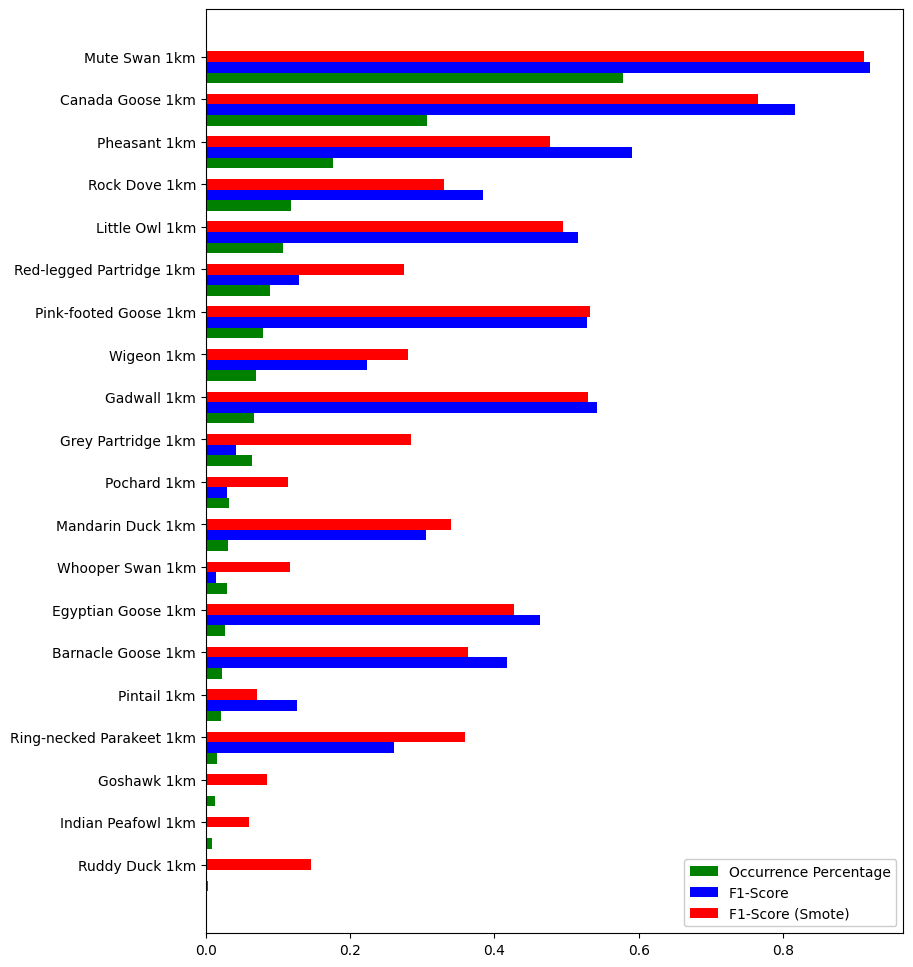

,Labels,Precision,Precision (Smote),Recall,Recall (Smote),F1,F1 (Smote),Occurrence Count,Percentage
9,Mute Swan 1km,0.895056,0.901090,0.947652,0.923650,0.920603,0.912231,19124,0.578044
1,Canada Goose 1km,0.751229,0.762679,0.893219,0.767732,0.816094,0.765197,10147,0.306704
10,Pheasant 1km,0.554217,0.523457,0.633609,0.438017,0.591260,0.476940,5855,0.176974
16,Rock Dove 1km,0.560799,0.477639,0.292337,0.252602,0.384328,0.330446,3919,0.118456
7,Little Owl 1km,0.533414,0.501166,0.500000,0.489749,0.516167,0.495392,3548,0.107242
14,Red-legged Partridge 1km,0.400000,0.424332,0.076814,0.203414,0.128878,0.275000,2953,0.089258
11,Pink-footed Goose 1km,0.676190,0.563884,0.432927,0.504573,0.527881,0.532582,2646,0.079978
19,Wigeon 1km,0.642276,0.244586,0.135043,0.328205,0.223164,0.280292,2317,0.070034
3,Gadwall 1km,0.709199,0.596330,0.438532,0.477064,0.541950,0.530071,2205,0.066649
5,Grey Partridge 1km,0.315789,0.345013,0.022727,0.242424,0.042403,0.284761,2123,0.064170


In [17]:
# Create graphs to show off data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 12]

occurrence_count, occurrence_percentage = All_bird_occurrences['Occurrence Count'], All_bird_occurrences['Percentage']
precision = []
precision_smote = []
recall = []
recall_smote = []
f1 = []
f1_smote = []
labels = []
for dict in df_dicts:
    precision.append(dict['report']['1']['precision'])
    precision_smote.append(dict['report_smote']['1']['precision'])
    recall.append(dict['report']['1']['recall'])
    recall_smote.append(dict['report_smote']['1']['recall'])
    f1.append(dict['report']['1']['f1-score'])
    f1_smote.append(dict['report_smote']['1']['f1-score'])
    labels.append(dict['name'])



scores = pd.DataFrame({'Labels' : labels, 
                        'Precision': precision, 'Precision (Smote)': precision_smote, 
                        'Recall': recall, 'Recall (Smote)': recall_smote, 
                        'F1': f1, 'F1 (Smote)': f1_smote,
                        'Occurrence Count' : occurrence_count, 'Percentage' : occurrence_percentage} )
                        
scores.sort_values('Occurrence Count', inplace=True)

n=20
r = np.arange(n)
height = 0.25

plt.barh(r, 'Percentage', data=scores, label='Occurrence Percentage', height = height, color='g')
plt.barh(r+height, 'F1', data=scores, label='F1-Score',  height= height, color='b')
plt.barh(r+height*2, 'F1 (Smote)', data=scores, label='F1-Score (Smote)',  height = height, color='r')
plt.legend(framealpha=1, frameon=True)
plt.yticks(r+height*2, scores['Labels'])


plt.show()


scores.sort_values('Occurrence Count', ascending=False)

In [13]:
# Store dictionaries for later use
df_dicts_1km = df_dicts
%store df_dicts_1km

Stored 'df_dicts_1km' (list)


In [14]:
# Export predictions to CSV for QGIS
RESULTS_PATH = 'Datasets/Machine Learning/Results/1km/'
for dict in df_dicts:
    # Join with y_test datafram
    result_df = dict['y_test'] 
    result_df['Predictions'] = dict['predictions_smote']
    display(result_df)
    result_df.to_csv(RESULTS_PATH + dict['name'] + '.csv')
    

,,Occurrence,Predictions
y,x,,
962500.0,155500.0,0,0
819500.0,338500.0,0,0
378500.0,406500.0,0,0
706500.0,390500.0,0,0
897500.0,325500.0,0,0
...,...,...,...
1096500.0,199500.0,0,0
535500.0,591500.0,0,0
337500.0,425500.0,0,0


,,Occurrence,Predictions
y,x,,
836500.0,116500.0,0,0
655500.0,626500.0,0,0
277500.0,451500.0,1,1
518500.0,61500.0,0,0
746500.0,117500.0,0,0
...,...,...,...
1017500.0,557500.0,0,0
374500.0,502500.0,1,0
248500.0,292500.0,0,0


,,Occurrence,Predictions
y,x,,
965500.0,565500.0,0,0
815500.0,297500.0,0,0
357500.0,224500.0,0,0
695500.0,254500.0,0,0
897500.0,689500.0,0,0
...,...,...,...
1097500.0,515500.0,0,0
516500.0,560500.0,0,0
315500.0,568500.0,0,0


,,Occurrence,Predictions
y,x,,
948500.0,472500.0,0,0
799500.0,389500.0,0,0
347500.0,652500.0,0,0
683500.0,615500.0,0,0
880500.0,575500.0,0,0
...,...,...,...
1086500.0,585500.0,0,0
499500.0,640500.0,0,0
312500.0,593500.0,0,0


,,Occurrence,Predictions
y,x,,
968500.0,51500.0,0,0
828500.0,230500.0,0,0
382500.0,480500.0,0,0
718500.0,624500.0,0,0
904500.0,666500.0,0,0
...,...,...,...
1099500.0,552500.0,0,0
540500.0,467500.0,0,0
337500.0,350500.0,0,0


,,Occurrence,Predictions
y,x,,
949500.0,6500.0,0,0
799500.0,470500.0,0,0
361500.0,282500.0,0,0
683500.0,278500.0,1,0
882500.0,446500.0,0,0
...,...,...,...
1091500.0,3500.0,0,0
505500.0,434500.0,0,0
323500.0,642500.0,0,1


,,Occurrence,Predictions
y,x,,
969500.0,180500.0,0,0
824500.0,179500.0,0,0
378500.0,407500.0,0,0
712500.0,336500.0,0,0
903500.0,422500.0,0,0
...,...,...,...
1099500.0,45500.0,0,0
531500.0,276500.0,0,0
334500.0,534500.0,0,0


,,Occurrence,Predictions
y,x,,
930500.0,568500.0,0,0
771500.0,130500.0,0,0
327500.0,11500.0,0,0
645500.0,485500.0,0,0
858500.0,506500.0,0,0
...,...,...,...
1074500.0,258500.0,0,0
456500.0,557500.0,0,0
293500.0,690500.0,0,0


,,Occurrence,Predictions
y,x,,
960500.0,209500.0,0,0
814500.0,197500.0,0,0
367500.0,436500.0,1,1
702500.0,371500.0,0,0
894500.0,360500.0,0,0
...,...,...,...
1096500.0,139500.0,0,0
521500.0,528500.0,0,0
325500.0,88500.0,0,0


,,Occurrence,Predictions
y,x,,
680500.0,65500.0,0,0
530500.0,309500.0,1,1
254500.0,634500.0,1,1
425500.0,348500.0,1,1
626500.0,529500.0,0,0
...,...,...,...
861500.0,205500.0,0,0
322500.0,344500.0,1,1
230500.0,483500.0,1,1


,,Occurrence,Predictions
y,x,,
902500.0,540500.0,0,0
739500.0,369500.0,0,0
317500.0,554500.0,0,1
622500.0,469500.0,0,0
828500.0,584500.0,0,0
...,...,...,...
1057500.0,582500.0,0,0
454500.0,632500.0,0,0
282500.0,318500.0,0,1


,,Occurrence,Predictions
y,x,,
950500.0,406500.0,0,0
809500.0,2500.0,0,0
398500.0,691500.0,0,0
707500.0,615500.0,0,0
881500.0,442500.0,0,0
...,...,...,...
1089500.0,549500.0,0,0
547500.0,154500.0,0,0
354500.0,260500.0,0,0


,,Occurrence,Predictions
y,x,,
967500.0,156500.0,0,1
822500.0,126500.0,0,0
378500.0,457500.0,0,0
709500.0,682500.0,0,0
900500.0,211500.0,0,0
...,...,...,...
1101500.0,468500.0,0,0
532500.0,374500.0,0,0
335500.0,560500.0,0,0


,,Occurrence,Predictions
y,x,,
961500.0,396500.0,0,0
818500.0,565500.0,0,0
371500.0,430500.0,0,1
704500.0,27500.0,0,0
896500.0,597500.0,0,0
...,...,...,...
1094500.0,461500.0,0,0
523500.0,617500.0,0,0
331500.0,11500.0,0,0


,,Occurrence,Predictions
y,x,,
940500.0,272500.0,0,0
782500.0,270500.0,0,0
336500.0,236500.0,0,1
664500.0,453500.0,0,0
868500.0,252500.0,0,0
...,...,...,...
1083500.0,173500.0,0,0
481500.0,553500.0,0,0
299500.0,527500.0,1,0


,,Occurrence,Predictions
y,x,,
969500.0,16500.0,0,0
821500.0,474500.0,0,0
368500.0,295500.0,0,0
709500.0,74500.0,0,0
903500.0,575500.0,0,0
...,...,...,...
1100500.0,390500.0,0,0
529500.0,393500.0,0,0
325500.0,323500.0,0,0


,,Occurrence,Predictions
y,x,,
937500.0,31500.0,0,0
778500.0,202500.0,0,0
335500.0,4500.0,0,0
659500.0,322500.0,1,0
863500.0,259500.0,1,0
...,...,...,...
1080500.0,155500.0,0,0
474500.0,477500.0,1,0
295500.0,95500.0,0,0


,,Occurrence,Predictions
y,x,,
969500.0,293500.0,0,0
825500.0,78500.0,0,0
379500.0,633500.0,0,0
713500.0,366500.0,0,0
901500.0,154500.0,0,0
...,...,...,...
1099500.0,316500.0,0,0
532500.0,141500.0,0,0
336500.0,138500.0,0,0


,,Occurrence,Predictions
y,x,,
965500.0,325500.0,1,0
825500.0,144500.0,1,0
386500.0,276500.0,0,1
713500.0,82500.0,0,0
903500.0,171500.0,0,0
...,...,...,...
1095500.0,145500.0,0,0
537500.0,428500.0,0,0
343500.0,467500.0,0,0


,,Occurrence,Predictions
y,x,,
952500.0,101500.0,0,0
810500.0,233500.0,0,0
374500.0,364500.0,1,1
698500.0,209500.0,0,0
884500.0,398500.0,0,0
...,...,...,...
1086500.0,454500.0,0,0
527500.0,207500.0,0,1
333500.0,528500.0,0,0


In [15]:
for dict in df_dicts:
    print(dict['name'])
    display(dict['kbest']['Dataframe'])

Barnacle Goose 1km


,F Score,P Value,Attribute
25,1586.660696,0.000000e+00,Inflowing drainage direction
29,1579.799646,0.000000e+00,Chlorothalonil
30,1579.799646,0.000000e+00,Glyphosate
31,1579.799646,0.000000e+00,Mancozeb
32,1579.799646,0.000000e+00,Mecoprop-P
34,1579.799646,0.000000e+00,Pendimethalin
18,1440.939379,1.143607e-308,Saltmarsh
23,1417.879628,7.271005e-304,Surface type
22,1269.611405,6.667737e-273,Cumulative catchment area
24,1223.198053,3.502336e-263,Outflowing drainage direction


Canada Goose 1km


,F Score,P Value,Attribute
29,31307.822741,0.000000e+00,Chlorothalonil
30,31307.822741,0.000000e+00,Glyphosate
31,31307.822741,0.000000e+00,Mancozeb
32,31307.822741,0.000000e+00,Mecoprop-P
34,31307.822741,0.000000e+00,Pendimethalin
23,27980.651957,0.000000e+00,Surface type
26,27539.757586,0.000000e+00,Fertiliser K
27,27539.757586,0.000000e+00,Fertiliser N
28,27539.757586,0.000000e+00,Fertiliser P
24,22192.853532,0.000000e+00,Outflowing drainage direction


Egyptian Goose 1km


,F Score,P Value,Attribute
26,4833.620741,0.000000e+00,Fertiliser K
27,4833.620741,0.000000e+00,Fertiliser N
28,4833.620741,0.000000e+00,Fertiliser P
22,4398.345684,0.000000e+00,Cumulative catchment area
13,3391.728526,0.000000e+00,Freshwater
29,3198.335134,0.000000e+00,Chlorothalonil
30,3198.335134,0.000000e+00,Glyphosate
31,3198.335134,0.000000e+00,Mancozeb
32,3198.335134,0.000000e+00,Mecoprop-P
34,3198.335134,0.000000e+00,Pendimethalin


Gadwall 1km


,F Score,P Value,Attribute
26,8495.245130,0.000000e+00,Fertiliser K
27,8495.245130,0.000000e+00,Fertiliser N
28,8495.245130,0.000000e+00,Fertiliser P
29,7138.523124,0.000000e+00,Chlorothalonil
30,7138.523124,0.000000e+00,Glyphosate
31,7138.523124,0.000000e+00,Mancozeb
32,7138.523124,0.000000e+00,Mecoprop-P
34,7138.523124,0.000000e+00,Pendimethalin
37,6747.511680,0.000000e+00,Sulphur
36,6716.673071,0.000000e+00,Prosulfocarb


Goshawk 1km


,F Score,P Value,Attribute
23,1228.008833,3.437230e-264,Surface type
21,1131.658994,5.687958e-244,Elevation
29,1110.016642,2.016393e-239,Chlorothalonil
30,1110.016642,2.016393e-239,Glyphosate
31,1110.016642,2.016393e-239,Mancozeb
32,1110.016642,2.016393e-239,Mecoprop-P
34,1110.016642,2.016393e-239,Pendimethalin
24,1068.037277,1.373575e-230,Outflowing drainage direction
22,1044.933301,1.009602e-225,Cumulative catchment area
25,919.889067,2.517246e-199,Inflowing drainage direction


Grey Partridge 1km


,F Score,P Value,Attribute
26,8765.050569,0.000000e+00,Fertiliser K
27,8765.050569,0.000000e+00,Fertiliser N
28,8765.050569,0.000000e+00,Fertiliser P
37,8712.410120,0.000000e+00,Sulphur
36,8711.451485,0.000000e+00,Prosulfocarb
38,8703.792647,0.000000e+00,Tri-allate
2,8141.700589,0.000000e+00,Arable
32,7660.609011,0.000000e+00,Mecoprop-P
29,7659.048939,0.000000e+00,Chlorothalonil
30,7659.048939,0.000000e+00,Glyphosate


Indian Peafowl 1km


,F Score,P Value,Attribute
26,1472.657485,2.862598e-315,Fertiliser K
27,1472.657485,2.862598e-315,Fertiliser N
28,1472.657485,2.862598e-315,Fertiliser P
36,1175.153234,4.174421e-253,Prosulfocarb
37,1172.615821,1.422851e-252,Sulphur
38,1166.318796,2.985253e-251,Tri-allate
29,1150.513144,6.221230e-248,Chlorothalonil
30,1150.513144,6.221230e-248,Glyphosate
31,1150.513144,6.221230e-248,Mancozeb
32,1150.513144,6.221230e-248,Mecoprop-P


Little Owl 1km


,F Score,P Value,Attribute
26,19475.045822,0.000000e+00,Fertiliser K
27,19475.045822,0.000000e+00,Fertiliser N
28,19475.045822,0.000000e+00,Fertiliser P
36,14464.783437,0.000000e+00,Prosulfocarb
37,14463.764574,0.000000e+00,Sulphur
38,14420.985632,0.000000e+00,Tri-allate
32,13365.596356,0.000000e+00,Mecoprop-P
29,13362.750579,0.000000e+00,Chlorothalonil
30,13362.750579,0.000000e+00,Glyphosate
31,13362.750579,0.000000e+00,Mancozeb


Mandarin Duck 1km


,F Score,P Value,Attribute
26,4982.270656,0.000000e+00,Fertiliser K
27,4982.270656,0.000000e+00,Fertiliser N
28,4982.270656,0.000000e+00,Fertiliser P
29,3746.947882,0.000000e+00,Chlorothalonil
30,3746.947882,0.000000e+00,Glyphosate
31,3746.947882,0.000000e+00,Mancozeb
32,3746.947882,0.000000e+00,Mecoprop-P
34,3746.947882,0.000000e+00,Pendimethalin
22,3559.780952,0.000000e+00,Cumulative catchment area
0,3525.975295,0.000000e+00,Deciduous woodland


Mute Swan 1km


,F Score,P Value,Attribute
30,43676.953726,0.000000e+00,Glyphosate
34,43676.953726,0.000000e+00,Pendimethalin
29,43659.642747,0.000000e+00,Chlorothalonil
31,43642.342398,0.000000e+00,Mancozeb
32,43625.052671,0.000000e+00,Mecoprop-P
23,41778.683149,0.000000e+00,Surface type
25,37707.864005,0.000000e+00,Inflowing drainage direction
21,32149.803935,0.000000e+00,Elevation
24,24629.730532,0.000000e+00,Outflowing drainage direction
26,19640.235987,0.000000e+00,Fertiliser K


Pheasant 1km


,F Score,P Value,Attribute
31,16151.612969,0.000000e+00,Mancozeb
32,16151.612969,0.000000e+00,Mecoprop-P
29,16147.891932,0.000000e+00,Chlorothalonil
30,16147.891932,0.000000e+00,Glyphosate
34,16147.891932,0.000000e+00,Pendimethalin
23,14828.439300,0.000000e+00,Surface type
26,13583.366928,0.000000e+00,Fertiliser K
27,13583.366928,0.000000e+00,Fertiliser N
28,13583.366928,0.000000e+00,Fertiliser P
24,12411.664397,0.000000e+00,Outflowing drainage direction


Pink-footed Goose 1km


,F Score,P Value,Attribute
29,7036.747030,0.000000e+00,Chlorothalonil
30,7036.747030,0.000000e+00,Glyphosate
31,7036.747030,0.000000e+00,Mancozeb
32,7036.747030,0.000000e+00,Mecoprop-P
34,7036.747030,0.000000e+00,Pendimethalin
25,5823.246006,0.000000e+00,Inflowing drainage direction
23,5796.329675,0.000000e+00,Surface type
37,5571.993565,0.000000e+00,Sulphur
36,5543.722242,0.000000e+00,Prosulfocarb
38,5512.222341,0.000000e+00,Tri-allate


Pintail 1km


,F Score,P Value,Attribute
29,1342.972285,3.070953e-288,Chlorothalonil
30,1342.972285,3.070953e-288,Glyphosate
31,1342.972285,3.070953e-288,Mancozeb
32,1342.972285,3.070953e-288,Mecoprop-P
34,1342.972285,3.070953e-288,Pendimethalin
25,1325.168183,1.608067e-284,Inflowing drainage direction
23,1169.840995,5.439990e-252,Surface type
36,1152.405110,2.491814e-248,Prosulfocarb
37,1150.598093,5.970826e-248,Sulphur
38,1144.636386,1.067303e-246,Tri-allate


Pochard 1km


,F Score,P Value,Attribute
26,2536.936766,0.000000e+00,Fertiliser K
27,2536.936766,0.000000e+00,Fertiliser N
28,2536.936766,0.000000e+00,Fertiliser P
29,2457.352155,0.000000e+00,Chlorothalonil
30,2457.352155,0.000000e+00,Glyphosate
31,2457.352155,0.000000e+00,Mancozeb
32,2457.352155,0.000000e+00,Mecoprop-P
34,2457.352155,0.000000e+00,Pendimethalin
37,2207.208744,0.000000e+00,Sulphur
36,2202.231304,0.000000e+00,Prosulfocarb


Red-legged Partridge 1km


,F Score,P Value,Attribute
26,13523.622232,0.000000e+00,Fertiliser K
27,13523.622232,0.000000e+00,Fertiliser N
28,13523.622232,0.000000e+00,Fertiliser P
37,11673.899484,0.000000e+00,Sulphur
36,11667.108199,0.000000e+00,Prosulfocarb
38,11666.574791,0.000000e+00,Tri-allate
29,10659.554341,0.000000e+00,Chlorothalonil
30,10659.554341,0.000000e+00,Glyphosate
31,10659.554341,0.000000e+00,Mancozeb
32,10659.554341,0.000000e+00,Mecoprop-P


Ring-necked Parakeet 1km


,F Score,P Value,Attribute
20,5174.029480,0.000000e+00,Suburban
19,4816.293327,0.000000e+00,Urban
26,2496.791010,0.000000e+00,Fertiliser K
27,2496.791010,0.000000e+00,Fertiliser N
28,2496.791010,0.000000e+00,Fertiliser P
22,2110.055997,0.000000e+00,Cumulative catchment area
29,1731.345378,0.000000e+00,Chlorothalonil
31,1731.345378,0.000000e+00,Mancozeb
32,1731.345378,0.000000e+00,Mecoprop-P
30,1731.004980,0.000000e+00,Glyphosate


Rock Dove 1km


,F Score,P Value,Attribute
29,11974.716865,0.000000e+00,Chlorothalonil
30,11974.716865,0.000000e+00,Glyphosate
31,11974.716865,0.000000e+00,Mancozeb
32,11974.716865,0.000000e+00,Mecoprop-P
34,11974.716865,0.000000e+00,Pendimethalin
23,9715.208896,0.000000e+00,Surface type
26,9320.817826,0.000000e+00,Fertiliser K
27,9320.817826,0.000000e+00,Fertiliser N
28,9320.817826,0.000000e+00,Fertiliser P
24,7716.649425,0.000000e+00,Outflowing drainage direction


Ruddy Duck 1km


,F Score,P Value,Attribute
13,2084.023887,0.000000e+00,Freshwater
26,611.973820,6.880144e-134,Fertiliser K
27,611.973820,6.880144e-134,Fertiliser N
28,611.973820,6.880144e-134,Fertiliser P
24,574.800456,6.036397e-126,Outflowing drainage direction
22,439.953763,4.753911e-97,Cumulative catchment area
29,420.253312,8.124948e-93,Chlorothalonil
31,420.253312,8.124948e-93,Mancozeb
32,420.253312,8.124948e-93,Mecoprop-P
30,420.170729,8.463895e-93,Glyphosate


Whooper Swan 1km


,F Score,P Value,Attribute
25,1676.560528,0.000000e+00,Inflowing drainage direction
23,1555.884294,0.000000e+00,Surface type
21,1411.884325,1.291051e-302,Elevation
29,1368.299617,1.585328e-293,Chlorothalonil
31,1368.299617,1.585328e-293,Mancozeb
32,1368.299617,1.585328e-293,Mecoprop-P
30,1367.972943,1.854762e-293,Glyphosate
34,1367.972943,1.854762e-293,Pendimethalin
24,1295.050837,3.175931e-278,Outflowing drainage direction
22,1252.169594,2.987125e-269,Cumulative catchment area


Wigeon 1km


,F Score,P Value,Attribute
29,4819.105469,0.000000e+00,Chlorothalonil
30,4819.105469,0.000000e+00,Glyphosate
31,4819.105469,0.000000e+00,Mancozeb
32,4819.105469,0.000000e+00,Mecoprop-P
34,4819.105469,0.000000e+00,Pendimethalin
25,4543.858943,0.000000e+00,Inflowing drainage direction
23,4385.352401,0.000000e+00,Surface type
21,3772.569210,0.000000e+00,Elevation
37,3368.272204,0.000000e+00,Sulphur
36,3344.881952,0.000000e+00,Prosulfocarb
